In [1]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

import pandas as pd
from configparser import ConfigParser
from repo.MyConfigParser import MyConfigParser
from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts, MakeFuture
from repo.FileGenerator import *
from repo.Optimization import SavantPSO

In [2]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/ca/1 June Update/config ups ca.ini"
updated_config.read(config_in_path)
getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]

base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]
breakdown_ls = [config_dict['CLIENTINFO'][i] for i in [f'breakdown{i}' for i in range(1,5)] if config_dict['CLIENTINFO'][i] != None]

small_market_str = ''
pre_forecast_period_budget = float(config_dict['CLIENTINFO']['pre_forecast_period_budget'])
client_budget = float(config_dict['CLIENTINFO']['client_budget'])

save_date = config_dict['CLIENTINFO']['save_date']

In [3]:
# Get forecasters
bdDf = pd.read_csv(base_path + 'New_Cuts_df.csv')#.drop('Unnamed: 0', axis = 1)
cuts_df = bdDf.reset_index(drop = True)
cuts_df['forecaster_name_list'] =  cuts_df['market'] + ' ' + cuts_df['account_type'] + ' ' + cuts_df['funnel'] + '.pkl' #' 05.19.2021 Final.pkl'
cuts_df['periods'] = periods
forecasters_array = cuts_df.forecaster_name_list

# Get analytical file
analytical_file = pd.read_csv(analytical_file_path)
analytical_file['ds'] = pd.to_datetime(analytical_file['ds'])
analytical_file_check_version = analytical_file.copy()

# Get constrain file
constraint_file = pd.read_csv(constraint_file_name)

In [4]:
#today = datetime.date.today().strftime("%m.%d.%Y")# 
date='06.05.2024'
fileName = base_path + f'Pos Result {date}.csv' #today

In [7]:
#el delimitador se debe a que se subio manualmente el archivo, si no se subio de forma manual, se debe quitar
pos_df = pd.read_csv(fileName , delimiter= ';').drop('Unnamed: 0', axis = 1)
pos_df

,variable_splits,pos
0,Canada_-_Brand_Apr_2024,1.034661
1,Canada_-_Non_Brand_Apr_2024,1.033203
2,Canada_-_Brand_May_2024,1.134960
3,Canada_-_Non_Brand_May_2024,0.935940
4,Canada_-_Brand_Jun_2024,1.137731
5,Canada_-_Non_Brand_Jun_2024,0.936105
6,Canada_-_Brand_Jul_2024,0.996203
7,Canada_-_Non_Brand_Jul_2024,0.978751
8,Canada_-_Brand_Aug_2024,1.136464
9,Canada_-_Non_Brand_Aug_2024,0.927360


In [8]:
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights = pos_df.pos.to_numpy()

daily_simulated_forecast = resultPSO.ResultGenerator(inputWeights)

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: 156263.0
analytical_spend_latest_period: 380086.0
client_budget - analytical_spend_latest_period: 0


In [9]:
# %load_ext autoreload
# %autoreload 2
resultPSO = SavantPSO(cuts_df, analytical_file, constraint_file, config_dict)
inputWeights_base = np.ones(constraint_file.shape[0])

daily_simulated_forecast_base = resultPSO.ResultGenerator(inputWeights_base)

--------------Optimized spend isn't the same as what UPS planned.---------------
Test 1: total X next year:  435865.0 difference between planned and forecast X:  -0.0
yhat: 153484.0
analytical_spend_latest_period: 380085.99999999994
client_budget - analytical_spend_latest_period: 0


In [10]:
daily_simulated_forecast

,ds,region,market,account_type,funnel,Identifier,X,new_funnel,generic_cost,competitor_cost,...,Canada_-_Non_Brand_Dec_2024,Canada_-_Non_Brand_Jul_2024,Canada_-_Non_Brand_Jun_2024,Canada_-_Non_Brand_May_2024,Canada_-_Non_Brand_Nov_2024,Canada_-_Non_Brand_Oct_2024,Canada_-_Non_Brand_Sep_2024,AOV,ROAS,yhat
0,2024-04-25,Canada,Canada,-,Brand,L,2038.811058,0,0.0000,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,42.32,26.36,871.0
1,2024-04-25,Canada,Canada,-,Non_Brand,L,328.528764,0,53.9100,253.69,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,43.89,7.12,117.0
2,2024-04-26,Canada,Canada,-,Brand,L,2136.674502,0,0.0000,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,42.32,26.36,806.0
3,2024-04-26,Canada,Canada,-,Non_Brand,L,308.289427,0,38.2500,250.40,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,43.89,7.12,104.0
4,2024-04-27,Canada,Canada,-,Brand,L,770.351085,0,0.0000,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,42.32,26.36,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-12-29,Canada,Canada,-,Non_Brand,L,436.326843,0,596.2025,44.62,...,436.326843,0.0,0.0,0.0,0.0,0.0,0.0,43.89,7.12,9.0
498,2024-12-30,Canada,Canada,-,Brand,L,762.383511,0,0.0000,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,42.32,26.36,278.0
499,2024-12-30,Canada,Canada,-,Non_Brand,L,520.620282,0,700.4022,64.22,...,520.620282,0.0,0.0,0.0,0.0,0.0,0.0,43.89,7.12,117.0
500,2024-12-31,Canada,Canada,-,Brand,L,2618.980785,0,0.0000,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,42.32,26.36,810.0


In [11]:
forecasted_daily_df = daily_simulated_forecast[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy()
forecasted_daily_df['month'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%b') #+ '/' + pd.to_datetime(result_df['ds']).dt.strftime('%Y')
forecasted_daily_df['year'] = pd.to_datetime(forecasted_daily_df['ds']).dt.strftime('%Y').astype(str)

forecasted_daily_df = forecasted_daily_df.rename(columns = { 'yhat': 'OptimalConversionQuantity', 'X': 'OptimalSpendValue'})
forecasted_daily_df['OptimalSpendValue'] = forecasted_daily_df['OptimalSpendValue'].round(2)

forecasted_daily_df['variable_splits'] = forecasted_daily_df['market'] + '_' + forecasted_daily_df['account_type']+'_'+forecasted_daily_df['funnel']+'_'+forecasted_daily_df['month']+'_'+forecasted_daily_df['year']
print(forecasted_daily_df.OptimalSpendValue.sum(), forecasted_daily_df.OptimalConversionQuantity.sum())
forecasted_daily_df.tail()

435864.47 156263.0


,market,account_type,funnel,ds,OptimalConversionQuantity,OptimalSpendValue,month,year,variable_splits
497,Canada,-,Non_Brand,2024-12-29,9.0,436.33,Dec,2024,Canada_-_Non_Brand_Dec_2024
498,Canada,-,Brand,2024-12-30,278.0,762.38,Dec,2024,Canada_-_Brand_Dec_2024
499,Canada,-,Non_Brand,2024-12-30,117.0,520.62,Dec,2024,Canada_-_Non_Brand_Dec_2024
500,Canada,-,Brand,2024-12-31,810.0,2618.98,Dec,2024,Canada_-_Brand_Dec_2024
501,Canada,-,Non_Brand,2024-12-31,135.0,1062.74,Dec,2024,Canada_-_Non_Brand_Dec_2024


In [12]:
base_daily_df = daily_simulated_forecast_base[['market', 'account_type', 'funnel', 'ds', 'yhat', 'X']].copy()
base_daily_df['month'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%b') #+ '/' + pd.to_datetime(result_df['ds']).dt.strftime('%Y')
base_daily_df['year'] = pd.to_datetime(base_daily_df['ds']).dt.strftime('%Y').astype(str)
base_daily_df['X'] = base_daily_df['X'].round(2)
base_daily_df = base_daily_df.rename(columns = { 'X': 'BaseSpend', 'yhat': 'BaseConversionQuantity'})

print(base_daily_df.BaseSpend.sum(), base_daily_df.BaseConversionQuantity.sum())
base_daily_df

435864.45 153484.0


,market,account_type,funnel,ds,BaseConversionQuantity,BaseSpend,month,year
0,Canada,-,Brand,2024-04-25,895.0,2145.05,Apr,2024
1,Canada,-,Non_Brand,2024-04-25,117.0,346.14,Apr,2024
2,Canada,-,Brand,2024-04-26,830.0,2248.01,Apr,2024
3,Canada,-,Non_Brand,2024-04-26,104.0,324.81,Apr,2024
4,Canada,-,Brand,2024-04-27,113.0,810.49,Apr,2024
...,...,...,...,...,...,...,...,...
497,Canada,-,Non_Brand,2024-12-29,11.0,535.53,Dec,2024
498,Canada,-,Brand,2024-12-30,232.0,644.78,Dec,2024
499,Canada,-,Non_Brand,2024-12-30,119.0,638.99,Dec,2024
500,Canada,-,Brand,2024-12-31,735.0,2214.97,Dec,2024


In [13]:
forecast_n_base_df = pd.merge(forecasted_daily_df, base_daily_df, how = 'left', on = ['market', 'account_type', 'funnel', 'ds', 'month', 'year'])
forecast_n_base_df['SavedDate'] = datetime.datetime.strptime(save_date, '_%m_%d_%y').strftime("%Y-%m-%d")

forecast_n_base_df.head()

,market,account_type,funnel,ds,OptimalConversionQuantity,OptimalSpendValue,month,year,variable_splits,BaseConversionQuantity,BaseSpend,SavedDate
0,Canada,-,Brand,2024-04-25,871.0,2038.81,Apr,2024,Canada_-_Brand_Apr_2024,895.0,2145.05,2024-06-01
1,Canada,-,Non_Brand,2024-04-25,117.0,328.53,Apr,2024,Canada_-_Non_Brand_Apr_2024,117.0,346.14,2024-06-01
2,Canada,-,Brand,2024-04-26,806.0,2136.67,Apr,2024,Canada_-_Brand_Apr_2024,830.0,2248.01,2024-06-01
3,Canada,-,Non_Brand,2024-04-26,104.0,308.29,Apr,2024,Canada_-_Non_Brand_Apr_2024,104.0,324.81,2024-06-01
4,Canada,-,Brand,2024-04-27,98.0,770.35,Apr,2024,Canada_-_Brand_Apr_2024,113.0,810.49,2024-06-01


# Large Market

In [14]:
lm_df = forecast_n_base_df.copy()
lm_split_df = pd.merge(lm_df, analytical_file[['market', 'funnel', 'ds', 'generic_cost_split', 'competitor_cost_split']], how = 'left', on = ['market', 'funnel', 'ds'])

# helper_df is used to get the investment split for each funnel
lm_generic_helper_df = lm_split_df.loc[lm_split_df['funnel'] == 'Non_Brand', ].copy()
lm_generic_helper_df.loc[:,'funnel'] = 'Generic'
lm_generic_helper_df.loc[:,'OptimalSpendValue'] = lm_generic_helper_df['OptimalSpendValue'] * lm_generic_helper_df['generic_cost_split']
lm_generic_helper_df.loc[:,'OptimalConversionQuantity'] = lm_generic_helper_df['OptimalConversionQuantity'] * lm_generic_helper_df['generic_cost_split']#round(lm_generic_helper_df['OptimalConversionQuantity'] * lm_generic_helper_df['generic_cost_split'], 0)
lm_generic_helper_df.loc[:,'BaseSpend'] = lm_generic_helper_df['BaseSpend'] * lm_generic_helper_df['generic_cost_split']
lm_generic_helper_df.loc[:,'BaseConversionQuantity'] = lm_generic_helper_df['BaseConversionQuantity'] * lm_generic_helper_df['generic_cost_split'] #round(lm_generic_helper_df['BaseConversionQuantity'] * lm_generic_helper_df['generic_cost_split'], 0)

lm_competitor_helper_df = lm_split_df.loc[lm_split_df['funnel'] == 'Non_Brand', ].copy()
lm_competitor_helper_df.loc[:,'funnel'] = 'Competitor'
lm_competitor_helper_df.loc[:,'OptimalSpendValue'] = lm_competitor_helper_df['OptimalSpendValue'] * lm_competitor_helper_df['competitor_cost_split']
lm_competitor_helper_df.loc[:,'OptimalConversionQuantity'] = lm_competitor_helper_df['OptimalConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'] #round(lm_competitor_helper_df['OptimalConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'], 0)
lm_competitor_helper_df.loc[:,'BaseSpend'] = lm_competitor_helper_df['BaseSpend'] * lm_competitor_helper_df['competitor_cost_split']
lm_competitor_helper_df.loc[:,'BaseConversionQuantity'] = lm_competitor_helper_df['BaseConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'] #round(lm_competitor_helper_df['BaseConversionQuantity'] * lm_competitor_helper_df['competitor_cost_split'], 0)

lm_funnel_level_daily_df = pd.concat([lm_split_df[(lm_split_df['funnel'] == 'Brand') | (lm_split_df['funnel'] == '-')], lm_generic_helper_df, lm_competitor_helper_df])
print(lm_funnel_level_daily_df.market.unique())
lm_funnel_level_daily_df.head()

['Canada']


,market,account_type,funnel,ds,OptimalConversionQuantity,OptimalSpendValue,month,year,variable_splits,BaseConversionQuantity,BaseSpend,SavedDate,generic_cost_split,competitor_cost_split
0,Canada,-,Brand,2024-04-25,871.0,2038.81,Apr,2024,Canada_-_Brand_Apr_2024,895.0,2145.05,2024-06-01,0.5,0.5
2,Canada,-,Brand,2024-04-26,806.0,2136.67,Apr,2024,Canada_-_Brand_Apr_2024,830.0,2248.01,2024-06-01,0.5,0.5
4,Canada,-,Brand,2024-04-27,98.0,770.35,Apr,2024,Canada_-_Brand_Apr_2024,113.0,810.49,2024-06-01,0.5,0.5
6,Canada,-,Brand,2024-04-28,134.0,810.83,Apr,2024,Canada_-_Brand_Apr_2024,150.0,853.08,2024-06-01,0.5,0.5
8,Canada,-,Brand,2024-04-29,835.0,2135.31,Apr,2024,Canada_-_Brand_Apr_2024,859.0,2246.57,2024-06-01,0.5,0.5


In [15]:
analytical_file.columns

Index(['ds', 'region', 'market', 'account_type', 'funnel', 'Identifier', 'X',
       'new_funnel', 'generic_cost', 'competitor_cost', 'generic_cost_split',
       'competitor_cost_split', 'Weekend', 'Month', 'Year',
       'Canada_-_Brand_Apr_2024', 'Canada_-_Brand_Aug_2024',
       'Canada_-_Brand_Dec_2024', 'Canada_-_Brand_Jul_2024',
       'Canada_-_Brand_Jun_2024', 'Canada_-_Brand_May_2024',
       'Canada_-_Brand_Nov_2024', 'Canada_-_Brand_Oct_2024',
       'Canada_-_Brand_Sep_2024', 'Canada_-_Non_Brand_Apr_2024',
       'Canada_-_Non_Brand_Aug_2024', 'Canada_-_Non_Brand_Dec_2024',
       'Canada_-_Non_Brand_Jul_2024', 'Canada_-_Non_Brand_Jun_2024',
       'Canada_-_Non_Brand_May_2024', 'Canada_-_Non_Brand_Nov_2024',
       'Canada_-_Non_Brand_Oct_2024', 'Canada_-_Non_Brand_Sep_2024', 'AOV',
       'ROAS'],
      dtype='object')

In [16]:
lm_funnel_level_daily_df = lm_funnel_level_daily_df.rename(columns=lambda x: x[0:1].upper() + x[1:])
lm_funnel_level_daily_df = lm_funnel_level_daily_df.drop(['Variable_splits', 'Generic_cost_split', 'Competitor_cost_split'], axis = 1)
lm_funnel_level_daily_df

,Market,Account_type,Funnel,Ds,OptimalConversionQuantity,OptimalSpendValue,Month,Year,BaseConversionQuantity,BaseSpend,SavedDate
0,Canada,-,Brand,2024-04-25,871.000000,2038.810000,Apr,2024,895.000000,2145.050000,2024-06-01
2,Canada,-,Brand,2024-04-26,806.000000,2136.670000,Apr,2024,830.000000,2248.010000,2024-06-01
4,Canada,-,Brand,2024-04-27,98.000000,770.350000,Apr,2024,113.000000,810.490000,2024-06-01
6,Canada,-,Brand,2024-04-28,134.000000,810.830000,Apr,2024,150.000000,853.080000,2024-06-01
8,Canada,-,Brand,2024-04-29,835.000000,2135.310000,Apr,2024,859.000000,2246.570000,2024-06-01
...,...,...,...,...,...,...,...,...,...,...,...
493,Canada,-,Competitor,2024-12-27,16.364588,100.239503,Dec,2024,16.791490,123.030393,2024-06-01
495,Canada,-,Competitor,2024-12-28,0.907475,42.922653,Dec,2024,1.088970,52.681637,2024-06-01
497,Canada,-,Competitor,2024-12-29,0.626663,30.381337,Dec,2024,0.765922,37.288561,2024-06-01
499,Canada,-,Competitor,2024-12-30,9.826735,43.726453,Dec,2024,9.994714,53.668253,2024-06-01


In [17]:
LM_SM_three_funnel_df = pd.concat([pd.DataFrame(), lm_funnel_level_daily_df]).reset_index(drop = True)
LM_SM_three_funnel_df.insert(3, 'WeekStart', [ i for i in LM_SM_three_funnel_df.Ds.apply(lambda x: x - pd.offsets.Week(weekday=6) )])
LM_SM_three_funnel_df.insert(0, 'Region', region)
LM_SM_three_funnel_df

,Region,Market,Account_type,Funnel,WeekStart,Ds,OptimalConversionQuantity,OptimalSpendValue,Month,Year,BaseConversionQuantity,BaseSpend,SavedDate
0,Canada,Canada,-,Brand,2024-04-21,2024-04-25,871.000000,2038.810000,Apr,2024,895.000000,2145.050000,2024-06-01
1,Canada,Canada,-,Brand,2024-04-21,2024-04-26,806.000000,2136.670000,Apr,2024,830.000000,2248.010000,2024-06-01
2,Canada,Canada,-,Brand,2024-04-21,2024-04-27,98.000000,770.350000,Apr,2024,113.000000,810.490000,2024-06-01
3,Canada,Canada,-,Brand,2024-04-21,2024-04-28,134.000000,810.830000,Apr,2024,150.000000,853.080000,2024-06-01
4,Canada,Canada,-,Brand,2024-04-28,2024-04-29,835.000000,2135.310000,Apr,2024,859.000000,2246.570000,2024-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,Canada,Canada,-,Competitor,2024-12-22,2024-12-27,16.364588,100.239503,Dec,2024,16.791490,123.030393,2024-06-01
749,Canada,Canada,-,Competitor,2024-12-22,2024-12-28,0.907475,42.922653,Dec,2024,1.088970,52.681637,2024-06-01
750,Canada,Canada,-,Competitor,2024-12-22,2024-12-29,0.626663,30.381337,Dec,2024,0.765922,37.288561,2024-06-01
751,Canada,Canada,-,Competitor,2024-12-29,2024-12-30,9.826735,43.726453,Dec,2024,9.994714,53.668253,2024-06-01


In [18]:
LM_SM_three_funnel_df[LM_SM_three_funnel_df['Ds'] >= '2024-06-01'].groupby(['Funnel', 'Month']).sum(numeric_only=1)

OptimalConversionQuantity  OptimalSpendValue  \
Funnel     Month                                                 
Brand      Aug                 16200.000000       45388.800000   
           Dec                 16969.000000       39317.140000   
           Jul                 17431.000000       45651.780000   
           Jun                 19009.000000       46886.480000   
           Nov                 14384.000000       45287.690000   
           Oct                 17705.000000       53318.250000   
           Sep                 14974.000000       41513.970000   
Competitor Aug                  1744.383578        3501.877338   
           Dec                   986.168701        4280.682423   
           Jul                  1752.395424        4055.436234   
           Jun                  1355.800898        4293.850662   
           Nov                   781.515855        3740.898645   
           Oct                  1357.881140        4584.044448   
           Sep                  1720.746769        6003.882683   
Generic    Aug                   453.616422        1004.942662   
           Dec                  2465.831299       12912.337577   
           Jul                   478.604576        1206.423766   
           Jun                   453.199102        1643.709338   
           Nov                  2107.484145       10529.331355   
           Oct                   843.118860        4101.295552   
           Sep                   230.253231         863.157317   

                  BaseConversionQuantity     BaseSpend  
Funnel     Month                                        
Brand      Aug              14750.000000  40477.750000  
           Dec              15145.000000  33251.950000  
           Jul              17650.000000  46444.350000  
           Jun              17709.000000  41766.800000  
           Nov              15476.000000  49588.960000  
           Oct              19075.000000  59083.820000  
           Sep              14269.000000  38671.100000  
Competitor Aug               1748.483237   3827.179443  
           Dec               1000.907482   5253.928094  
           Jul               1753.656424   4199.384008  
           Jun               1360.347490   4648.861562  
           Nov                787.830942   4169.170466  
           Oct               1363.906132   5036.540080  
           Sep               1729.668934   6513.603363  
Generic    Aug                454.516763   1098.300557  
           Dec               2512.092518  15848.061906  
           Jul                479.343576   1249.245992  
           Jun                454.652510   1779.608438  
           Nov               2126.169058  11734.779534  
           Oct                850.093868   4506.139920  
           Sep                231.331066    936.436637

In [19]:
LM_SM_three_funnel_df[LM_SM_three_funnel_df['Ds'] >= '2024-06-01'].sum(numeric_only=1)

OptimalConversionQuantity    133403.00
OptimalSpendValue            380085.98
BaseConversionQuantity       130927.00
BaseSpend                    380085.97
dtype: float64

In [20]:
# Construct a BigQuery client object.
bqclient = bigquery.Client()

target_table_name = 'budget_allocation_scenario_with_base_' + region + save_date
table_id = "ups-analytics.forecast_optimization." + target_table_name
print(table_id)
# job_config.
job_config = bigquery.LoadJobConfig(write_disposition = "WRITE_TRUNCATE")

load_job = bqclient.load_table_from_dataframe(
    LM_SM_three_funnel_df, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = bqclient.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))

ups-analytics.forecast_optimization.budget_allocation_scenario_with_base_Canada_06_01_24
Loaded 753 rows.


table = bqclient.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

In [21]:
LM_SM_three_funnel_df[LM_SM_three_funnel_df.Ds>='2024-06-01'].to_csv(base_path + 'output.csv',index=False)

2024-06-06 16:51:58,816 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:58,820 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:58,834 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


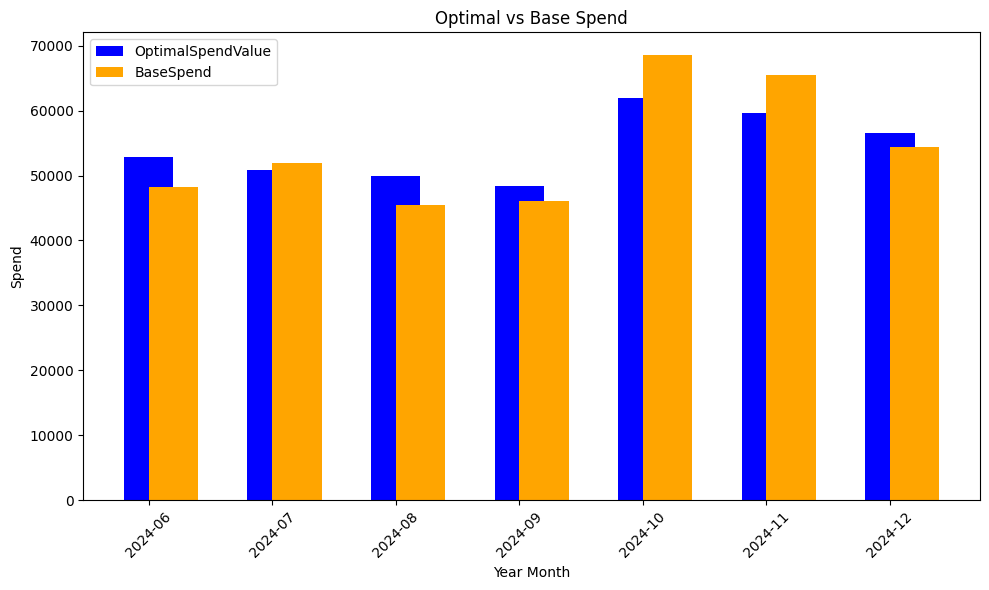

2024-06-06 16:51:59,177 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,180 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,194 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,219 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,

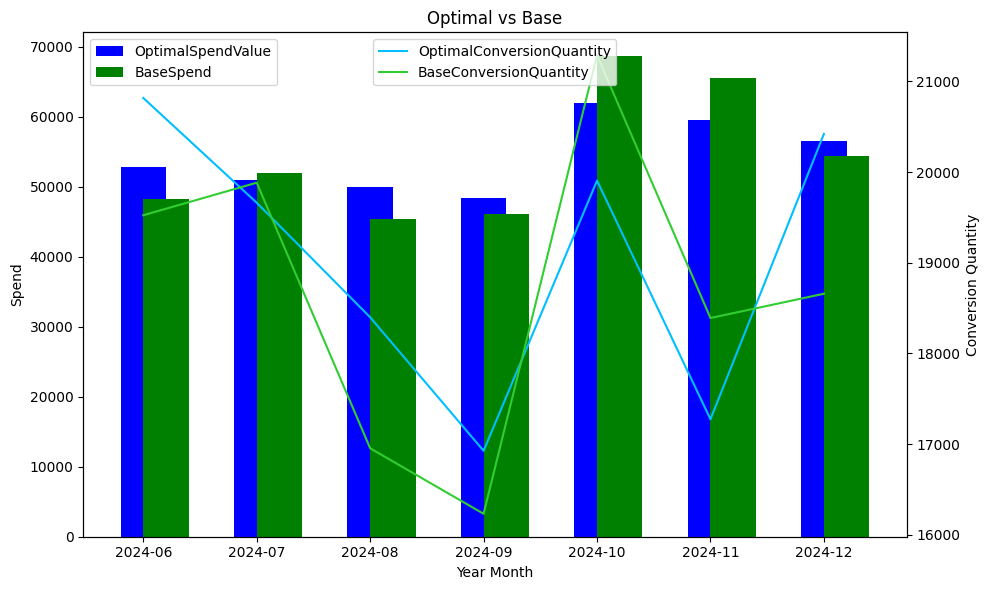

In [22]:
forecast = pd.read_csv(base_path + 'output.csv', index_col = 0) # read the best results df from prophet hyper parameter search
forecast['Ds'] = pd.to_datetime(forecast['Ds'])
# Convierte la columna 'Ds' en un objeto de período mensual y crea una nueva columna 'year_month'
forecast['year_month'] = forecast['Ds'].dt.to_period('M')

# Agrupa el DataFrame 'forecast' por la nueva columna 'year_month' y suma las columnas numéricas
forecast_by_month = forecast.groupby('year_month').sum(numeric_only=True)

forecast_by_month.reset_index(inplace=True)
forecast_by_month['year_month'] = forecast_by_month['year_month'].dt.strftime('%Y-%m')
 
forecast_by_split = forecast.groupby(['year_month','Funnel']).sum(numeric_only=1)
forecast_by_split.reset_index(inplace=True)
forecast_by_split['year_month'] = forecast_by_split['year_month'].dt.strftime('%Y-%m')
# Plot the bar graph
plt.figure(figsize=(10, 6))  # Set the size of the plot
 
# Plot OptimalConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
 
# Plot BaseConversionQuantity
plt.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='orange', width=0.4, label='BaseSpend', align='edge')
 
plt.xlabel('Year Month')
plt.ylabel('Spend')
plt.title('Optimal vs Base Spend')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
 
# Show the plot
plt.show()

# Plot the bar graph
fig, ax1 = plt.subplots(figsize=(10, 6))
 
# Plot OptimalConversionQuantity
ax1.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
# Plot BaseConversionQuantity
ax1.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base')
ax1.legend(loc='upper left')
 
 
ax2 = ax1.twinx()
ax2.plot(forecast_by_month['year_month'], forecast_by_month['OptimalConversionQuantity'], color='deepskyblue', label='OptimalConversionQuantity')
ax2.plot(forecast_by_month['year_month'], forecast_by_month['BaseConversionQuantity'], color='limegreen', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')
 
fig.tight_layout()
 
# Show the plot
plt.show()

2024-06-06 16:51:59,713 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,716 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,727 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,846 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:51:59,

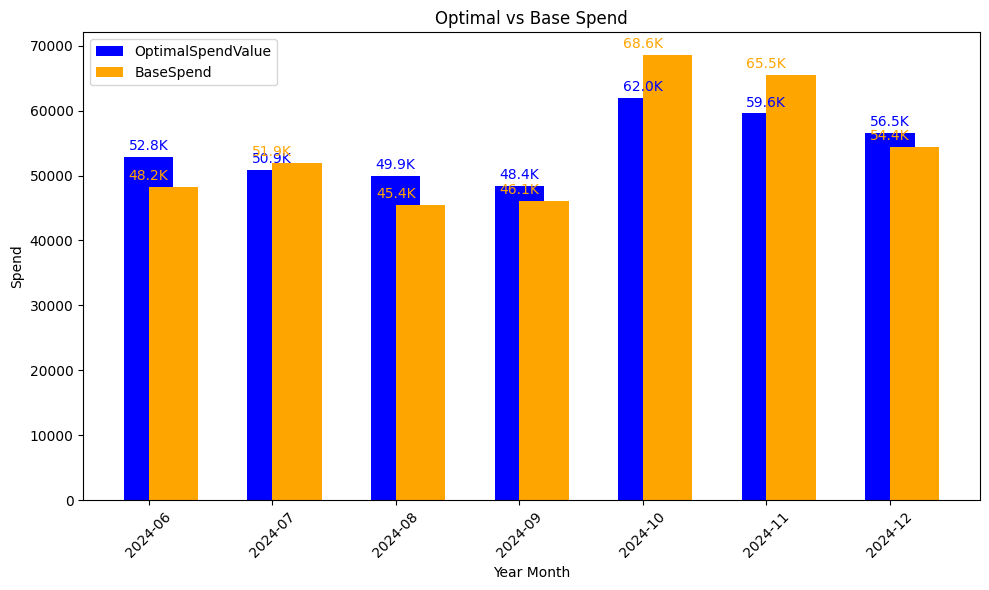

2024-06-06 16:52:00,500 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:00,503 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:00,512 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:00,538 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:00,

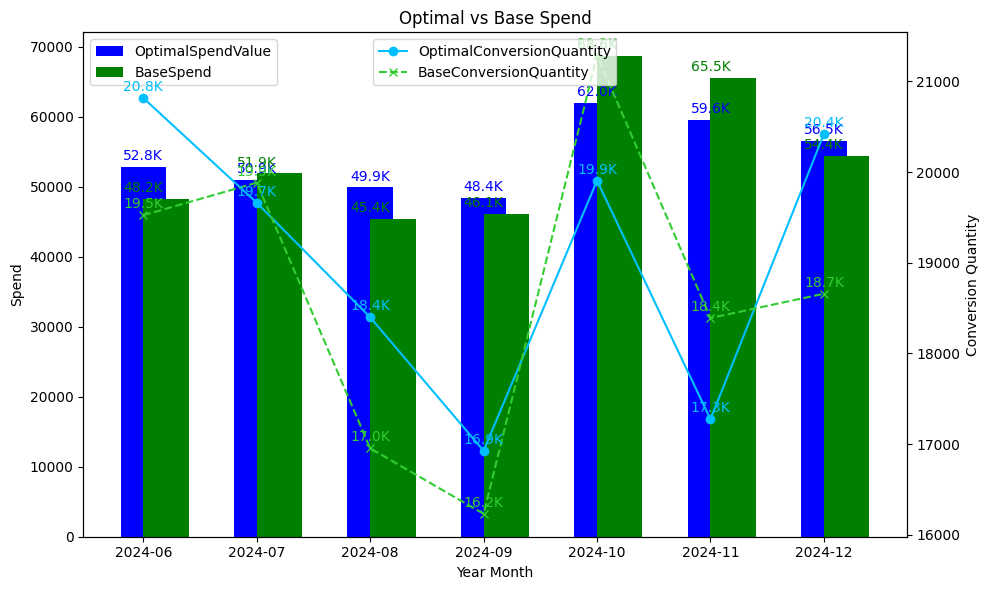

In [23]:
forecast = pd.read_csv(base_path + 'output.csv', index_col=0)

# Convertir la columna 'Ds' a datetime
forecast['Ds'] = pd.to_datetime(forecast['Ds'])

# Crear la columna 'year_month'
forecast['year_month'] = forecast['Ds'].dt.to_period('M')

# Agrupar el DataFrame por 'year_month' y sumar las columnas numéricas
forecast_by_month = forecast.groupby('year_month').sum(numeric_only=True)
forecast_by_month.reset_index(inplace=True)
forecast_by_month['year_month'] = forecast_by_month['year_month'].dt.strftime('%Y-%m')

forecast_by_split = forecast.groupby(['year_month', 'Funnel']).sum(numeric_only=True)
forecast_by_split.reset_index(inplace=True)
forecast_by_split['year_month'] = forecast_by_split['year_month'].dt.strftime('%Y-%m')

# Función para formatear los números grandes
def format_value(val):
    if val >= 1000:
        return f'{val / 1000:.1f}K'
    return str(val)

# Primer gráfico de barras
plt.figure(figsize=(10, 6))  # Tamaño del gráfico

# Graficar 'OptimalSpendValue'
plt.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')

# Graficar 'BaseSpend'
plt.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='orange', width=0.4, label='BaseSpend', align='edge')

plt.xlabel('Year Month')
plt.ylabel('Spend')
plt.title('Optimal vs Base Spend')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()  # Ajustar el layout para las etiquetas del eje x rotadas

# Mostrar valores en los puntos de datos
for i in range(len(forecast_by_month)):
    plt.annotate(format_value(forecast_by_month['OptimalSpendValue'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['OptimalSpendValue'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='blue')
    plt.annotate(format_value(forecast_by_month['BaseSpend'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['BaseSpend'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='orange')

# Mostrar el gráfico
plt.show()

# Segundo gráfico con doble eje y
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar 'OptimalSpendValue'
ax1.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')

# Graficar 'BaseSpend'
ax1.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
ax1.set_ylabel('Spend')
ax1.set_xlabel('Year Month')
ax1.set_title('Optimal vs Base Spend')
ax1.legend(loc='upper left')

# Añadir anotaciones para 'Spend'
for i in range(len(forecast_by_month)):
    ax1.annotate(format_value(forecast_by_month['OptimalSpendValue'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['OptimalSpendValue'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='blue')
    ax1.annotate(format_value(forecast_by_month['BaseSpend'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['BaseSpend'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='g')

# Segundo eje y para 'Conversion Quantity'
ax2 = ax1.twinx()
ax2.plot(forecast_by_month['year_month'], forecast_by_month['OptimalConversionQuantity'], color='deepskyblue', linestyle='-', marker='o', label='OptimalConversionQuantity')
ax2.plot(forecast_by_month['year_month'], forecast_by_month['BaseConversionQuantity'], color='limegreen', linestyle='--', marker='x', label='BaseConversionQuantity')
ax2.set_ylabel('Conversion Quantity')
ax2.legend(loc='upper center')
ax2.tick_params(axis='y')

# Añadir anotaciones para 'Conversion Quantity'
for i in range(len(forecast_by_month)):
    ax2.annotate(format_value(forecast_by_month['OptimalConversionQuantity'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['OptimalConversionQuantity'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='deepskyblue')
    ax2.annotate(format_value(forecast_by_month['BaseConversionQuantity'][i]), 
                 (forecast_by_month['year_month'][i], forecast_by_month['BaseConversionQuantity'][i]), 
                 textcoords="offset points", xytext=(0,5), ha='center', color='limegreen')

fig.tight_layout()

# Mostrar el gráfico
plt.show()

2024-06-06 16:52:02,319 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:02,324 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:02,340 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:02,630 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:02,

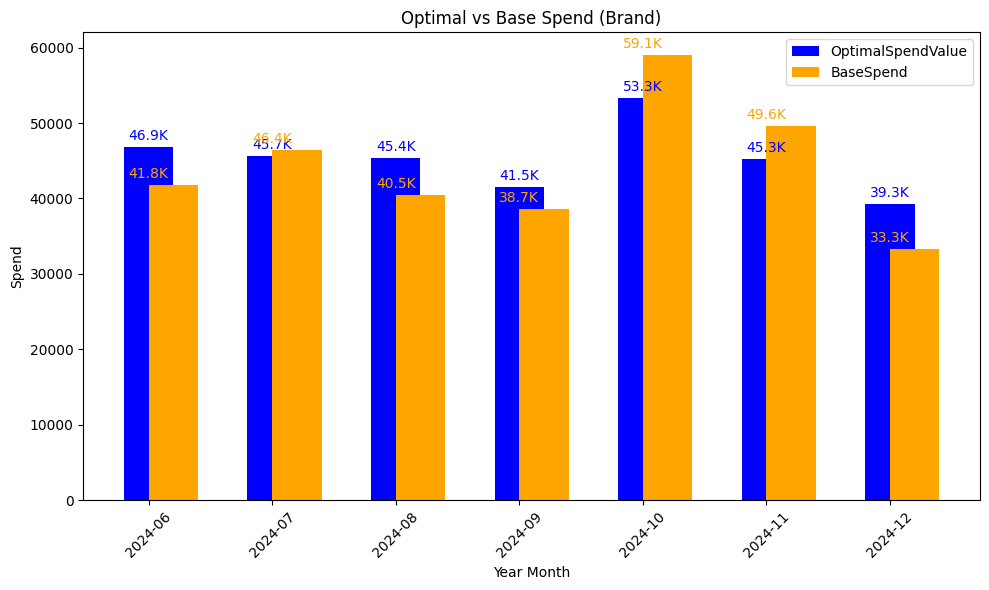

2024-06-06 16:52:03,316 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:03,320 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:03,332 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:03,372 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:03,

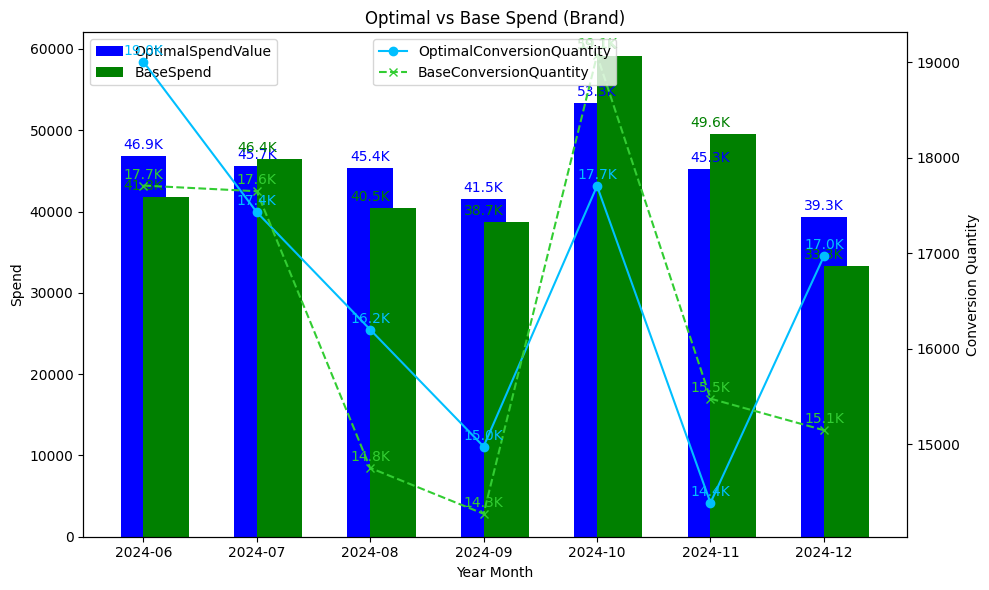

2024-06-06 16:52:04,811 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:04,814 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:04,823 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:04,941 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:04,

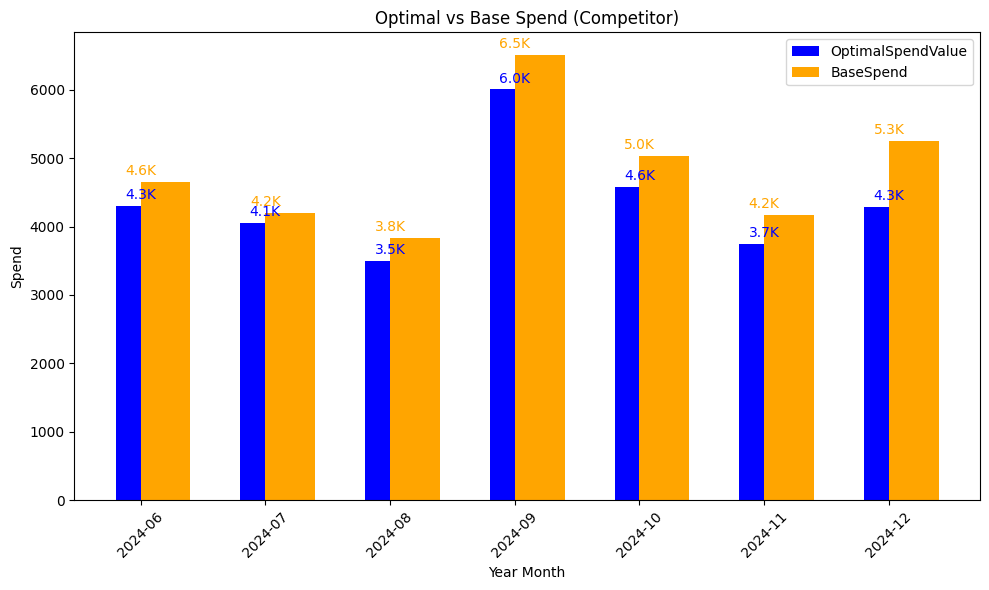

2024-06-06 16:52:05,510 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:05,513 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:05,522 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:05,549 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:05,

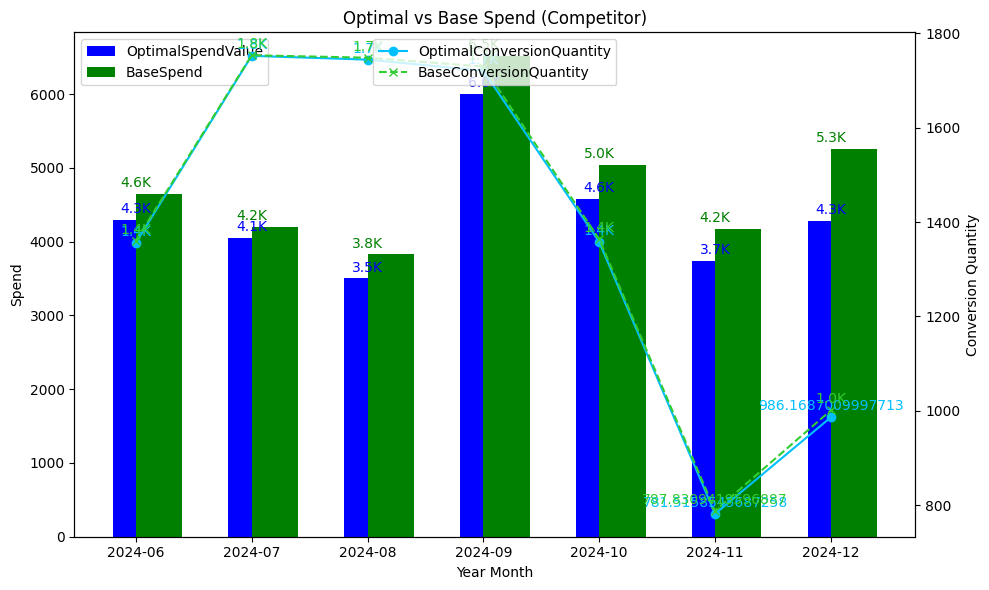

2024-06-06 16:52:06,946 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:06,949 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:06,961 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:07,080 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:07,

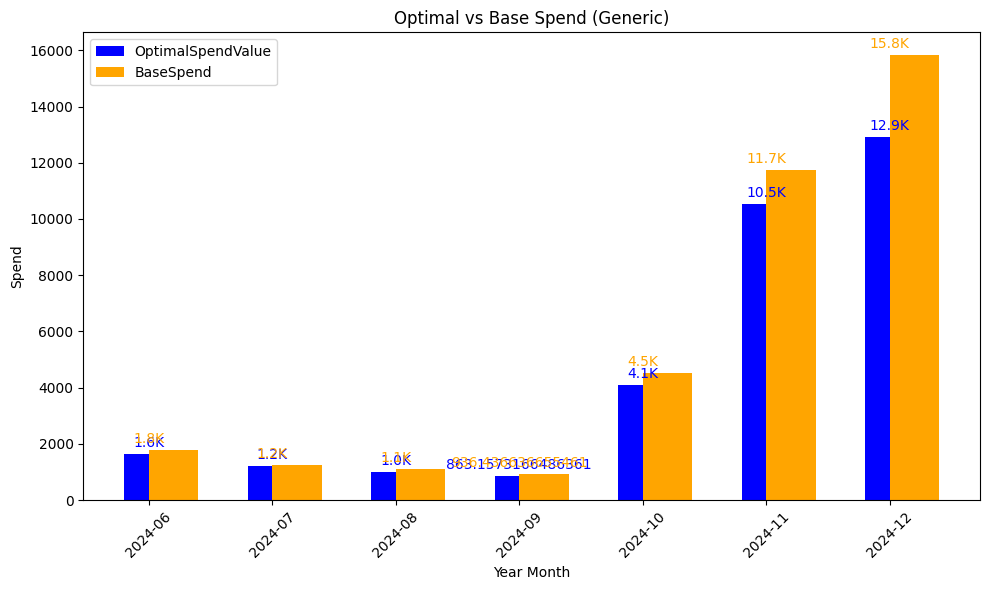

2024-06-06 16:52:07,669 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:07,672 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:07,681 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:07,708 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-06 16:52:07,

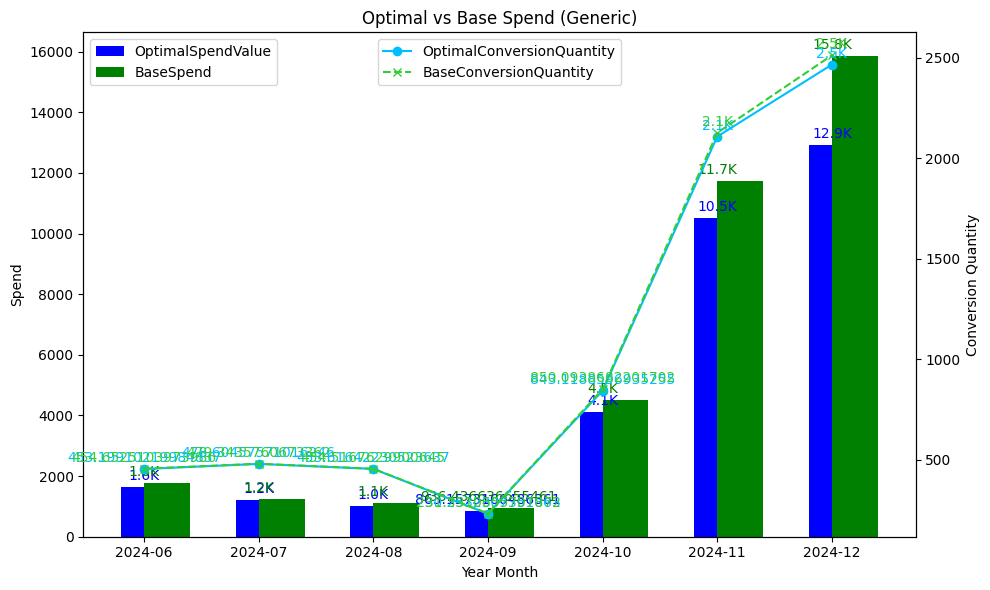

In [24]:
forecast = pd.read_csv(base_path + 'output.csv', index_col=0)

# Convertir la columna 'Ds' a datetime
forecast['Ds'] = pd.to_datetime(forecast['Ds'])

# Crear la columna 'year_month'
forecast['year_month'] = forecast['Ds'].dt.to_period('M')

# Función para formatear los números grandes
def format_value(val):
    if val >= 1000:
        return f'{val / 1000:.1f}K'
    return str(val)

# Filtrar por cada tipo de 'Funnel'
funnels = ['Brand', 'Competitor', 'Generic']
for funnel in funnels:
    # Filtrar el DataFrame por 'Funnel'
    funnel_data = forecast[forecast['Funnel'] == funnel]
    
    # Agrupar el DataFrame por 'year_month' y sumar las columnas numéricas
    forecast_by_month = funnel_data.groupby('year_month').sum(numeric_only=True)
    forecast_by_month.reset_index(inplace=True)
    forecast_by_month['year_month'] = forecast_by_month['year_month'].dt.strftime('%Y-%m')
    
    # Crear el gráfico de barras para el tipo de 'Funnel'
    plt.figure(figsize=(10, 6))  # Tamaño del gráfico
    
    # Graficar 'OptimalSpendValue'
    plt.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
    
    # Graficar 'BaseSpend'
    plt.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='orange', width=0.4, label='BaseSpend', align='edge')
    
    plt.xlabel('Year Month')
    plt.ylabel('Spend')
    plt.title(f'Optimal vs Base Spend ({funnel})')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()  # Ajustar el layout para las etiquetas del eje x rotadas
    
    # Mostrar valores en los puntos de datos
    for i in range(len(forecast_by_month)):
        plt.annotate(format_value(forecast_by_month['OptimalSpendValue'][i]), 
                     (forecast_by_month['year_month'][i], forecast_by_month['OptimalSpendValue'][i]), 
                     textcoords="offset points", xytext=(0,5), ha='center', color='blue')
        plt.annotate(format_value(forecast_by_month['BaseSpend'][i]), 
                     (forecast_by_month['year_month'][i], forecast_by_month['BaseSpend'][i]), 
                     textcoords="offset points", xytext=(0,5), ha='center', color='orange')
    
    # Mostrar el gráfico
    plt.show()
    
    # Crear el gráfico con doble eje y para el tipo de 'Funnel'
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Graficar 'OptimalSpendValue'
    ax1.bar(forecast_by_month['year_month'], forecast_by_month['OptimalSpendValue'], color='blue', width=0.4, label='OptimalSpendValue', align='center')
    
    # Graficar 'BaseSpend'
    ax1.bar(forecast_by_month['year_month'], forecast_by_month['BaseSpend'], color='g', width=0.4, label='BaseSpend', align='edge')
    ax1.set_ylabel('Spend')
    ax1.set_xlabel('Year Month')
    ax1.set_title(f'Optimal vs Base Spend ({funnel})')
    ax1.legend(loc='upper left')
    
    # Añadir anotaciones para 'Spend'
    for i in range(len(forecast_by_month)):
        ax1.annotate(format_value(forecast_by_month['OptimalSpendValue'][i]), 
                     (forecast_by_month['year_month'][i], forecast_by_month['OptimalSpendValue'][i]), 
                     textcoords="offset points", xytext=(0,5), ha='center', color='blue')
        ax1.annotate(format_value(forecast_by_month['BaseSpend'][i]), 
                     (forecast_by_month['year_month'][i], forecast_by_month['BaseSpend'][i]), 
                     textcoords="offset points", xytext=(0,5), ha='center', color='g')
    
    # Segundo eje y para 'Conversion Quantity'
    ax2 = ax1.twinx()
    ax2.plot(forecast_by_month['year_month'], forecast_by_month['OptimalConversionQuantity'], color='deepskyblue', linestyle='-', marker='o', label='OptimalConversionQuantity')
    ax2.plot(forecast_by_month['year_month'], forecast_by_month['BaseConversionQuantity'], color='limegreen', linestyle='--', marker='x', label='BaseConversionQuantity')
    ax2.set_ylabel('Conversion Quantity')
    ax2.legend(loc='upper center')
    ax2.tick_params(axis='y')
    
    # Añadir anotaciones para 'Conversion Quantity'
    for i in range(len(forecast_by_month)):
        ax2.annotate(format_value(forecast_by_month['OptimalConversionQuantity'][i]), 
                     (forecast_by_month['year_month'][i], forecast_by_month['OptimalConversionQuantity'][i]), 
                     textcoords="offset points", xytext=(0,5), ha='center', color='deepskyblue')
        ax2.annotate(format_value(forecast_by_month['BaseConversionQuantity'][i]), 
                     (forecast_by_month['year_month'][i], forecast_by_month['BaseConversionQuantity'][i]), 
                     textcoords="offset points", xytext=(0,5), ha='center', color='limegreen')
    
    fig.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

In [45]:
ratio1= LM_SM_three_funnel_df.copy()

In [34]:
ratio1['Ratio'] = ratio1['OptimalSpendValue'] / ratio1['OptimalConversionQuantity']

0    2.340769
1    2.650955
2    7.860714
3    6.050970
4    2.557257
Name: Ratio, dtype: float64

In [46]:
ratio1 = ratio1[ratio1['Ds'] >= '2024-06-01'].groupby(['Funnel', 'Month']).sum(numeric_only=1)

In [49]:
ratio2= ratio1['Ratio'] = ratio1['OptimalSpendValue'] / ratio1['OptimalConversionQuantity']
ratio2

Funnel      Month
Brand       Aug      2.801778
            Dec      2.316998
            Jul      2.618999
            Jun      2.466541
            Nov      3.148477
            Oct      3.011480
            Sep      2.772403
Competitor  Aug      2.007516
            Dec      4.340720
            Jul      2.314224
            Jun      3.167022
            Nov      4.786721
            Oct      3.375880
            Sep      3.489115
Generic     Aug      2.215402
            Dec      5.236505
            Jul      2.520711
            Jun      3.626903
            Nov      4.996162
            Oct      4.864433
            Sep      3.748731
dtype: float64